In [1]:
!pip install --upgrade hifi-gan-bwe

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.9/160.9 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 42.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 66.9 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 40.4 MB/s eta 0:00:0000:0100:01


In [15]:
import audioread
import numpy as np
import torch
from IPython.display import Audio
from hifi_gan_bwe import BandwidthExtender
import os
import time
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import decimate

In [16]:
model = BandwidthExtender.from_pretrained("hifi-gan-bwe-10-42890e3-vctk-48kHz")

In [17]:
originalFilePath = "FullBandFiles/p232_001.wav"

In [18]:
import numpy as np
import scipy.io.wavfile as wav

def print_wav_metadata(file_path):
    """
    Print metadata for a WAV file.
    
    Parameters:
    file_path (str): Path to the WAV file.
    """
    try:
        # Read the WAV file
        sample_rate, data = wav.read(file_path)
        
        # Determine the number of channels
        if len(data.shape) == 1:
            num_channels = 1
        else:
            num_channels = data.shape[1]
        
        # Calculate the duration of the WAV file in seconds
        duration = data.shape[0] / sample_rate
        
        # Print metadata
        print(f"Metadata for '{file_path}':")
        print(f" - Sample Rate: {sample_rate} Hz")
        print(f" - Number of Channels: {num_channels}")
        print(f" - Duration: {duration:.2f} seconds")
        print(f" - Number of Samples: {data.shape[0]}")
        print(f" - Data Type: {data.dtype}")
        print(f" - Minimum Value: {np.min(data)}")
        print(f" - Maximum Value: {np.max(data)}")
        print(f" - Mean Value: {np.mean(data)}")
        print(f" - Standard Deviation: {np.std(data)}")
    
    except Exception as e:
        print(f"An error occurred while reading the WAV file: {e}")


print_wav_metadata(originalFilePath)


Metadata for 'FullBandFiles/p232_001.wav':
 - Sample Rate: 48000 Hz
 - Number of Channels: 1
 - Duration: 1.74 seconds
 - Number of Samples: 83582
 - Data Type: int16
 - Minimum Value: -16384
 - Maximum Value: 15068
 - Mean Value: -1.164927855279845
 - Standard Deviation: 2962.60408447921


In [19]:
def compare_array_metadata(arr1, arr2):
    print("Array Metadata Comparison:")
    print(f"{'Property':<30} {'Array 1':<20} {'Array 2':<20}")
    print(f"{'-'*70}")
    print(f"{'Shape':<30} {str(arr1.shape):<20} {str(arr2.shape):<20}")
    print(f"{'Dimensions':<30} {arr1.ndim:<20} {arr2.ndim:<20}")
    print(f"{'Size (number of elements)':<30} {arr1.size:<20} {arr2.size:<20}")
    print(f"{'Data type':<30} {arr1.dtype:}              {arr2.dtype:}")
    print(f"{'Minimum value':<30} {arr1.min():<20} {arr2.min():<20}")
    print(f"{'Maximum value':<30} {arr1.max():<20} {arr2.max():<20}")
    print(f"{'Mean value':<30} {arr1.mean():<20} {arr2.mean():<20}")

In [20]:
fs, original_data = wav.read(originalFilePath)
original_data = original_data.astype(np.float32)/32767

In [21]:
new_fs = 16000
q = int(fs/new_fs)

def downsample_data2(data):
    downsampled_data = decimate(data, q, ftype='fir', zero_phase=True)
    new_downsampled_data = downsampled_data.reshape([-1, 1])

    return new_downsampled_data

downsampled_data = downsample_data2(original_data)

In [22]:
def run_model(downsampled_data):
    with torch.no_grad():
        y = np.stack([model(torch.from_numpy(downsampled_data), new_fs) for downsampled_data in downsampled_data.T]).T
        y = y.reshape(-1)
    return y

y = run_model(downsampled_data)

In [23]:
def find_fft_length(folderpath):
    max_length = 0
    wav_files = os.listdir(folderpath)
    for filename in wav_files:
        filepath = os.path.join(folderpath, filename)
        if filename[-4:].lower() != '.wav':
            continue
        sample_rate, data = wav.read(filepath)
        max_length = max(max_length, len(data))
    return 2**int(np.ceil(np.log2(max_length))), max_length+1

def pad_to_length(signal, length):
    padded_signal = np.zeros(length)
    padded_signal[:len(signal)] = signal
    return padded_signal

files = os.listdir('FullBandFiles')
i=0
j=0
for filename in files:
    j+=1
    if filename[-4:].lower() == '.wav':
        i+=1

print(i,j)

824 825


In [24]:
folderpath = 'FullBandFiles'
list_of_wavs = os.listdir(folderpath)
fs, original_data = wav.read(originalFilePath)
#fft_length =  int(len(original_data)/2)
#print(fft_length)
#fft_length = find_fft_length(folderpath) #524288
fft_length, data_length = find_fft_length(folderpath)

fft_arr_length = int(fft_length/2+1)
sum_squared_error = np.zeros(fft_arr_length)
sum_relative_error = np.zeros(fft_arr_length)
sum_original_fft = np.zeros(fft_arr_length)
sum_bwe_fft = np.zeros(fft_arr_length)

In [25]:
start_time = time.time()

fft_dict = {} #To store FFT data
count = 0
for index, filename in enumerate(list_of_wavs):
    
    #Fetch original data and convert to float32
    filepath = os.path.join(folderpath, filename)
    if filename[-4:].lower() != '.wav':
        continue
    fs, original_data = wav.read(filepath)
    original_data = original_data.astype(np.float32)/32767
    

    #Downsample data and prep for model
    downsampled_data = downsample_data2(original_data)
    

    #Run model
    bwe_data = run_model(downsampled_data)

    original_data = pad_to_length(original_data, data_length)
    bwe_data = pad_to_length(bwe_data, data_length)
    

    #Create FFTs
    original_fft = np.abs(np.fft.rfft(original_data, n = fft_length))
    bwe_fft = np.abs(np.fft.rfft(bwe_data, n = fft_length))
    
    #Save to FFTs dictionary
    fft_dict[f'arr1_{count}'] = original_fft
    fft_dict[f'arr2_{count}'] = bwe_fft
    count += 1
    
    #Timetracker
    temp_stop = time.time()
    temp_elapsed = int(temp_stop - start_time)
    if index%25==0:
        print(f'Iteration {index + 1} out of {len(list_of_wavs)}. Elapsed time: ' +
      (f'{temp_elapsed // 60} minutes and ' if temp_elapsed >= 60 else '') +
      f'{temp_elapsed % 60} seconds')


#Save FFT dictionary to file
fft_arrays = 'fft_arrayz.npz'
np.savez(fft_arrays, **fft_dict)

#Print running time
stop_time = time.time()
elapsed_time = int(stop_time - start_time)

print(f'Total running time for {len(list_of_wavs)} iterations: ' + (f'{elapsed_time // 60} minutes and ' if elapsed_time >= 60 else '') +
      f'{temp_elapsed % 60} seconds')

#compare_array_metadata(original_fft, bwe_fft)

Iteration 1 out of 825. Elapsed time: 2 seconds


KeyboardInterrupt: 

In [26]:
fft_errors = []
fft_arrays = 'fft_arrayz.npz'


with np.load(fft_arrays) as data:
    i = 0
    while f'arr1_{i}' in data:
        original_fft = data[f'arr1_{i}']
        bwe_fft = data[f'arr2_{i}']
        fft_error = np.abs(original_fft - bwe_fft)
        relative_fft_error = np.abs((original_fft - bwe_fft)/(original_fft))*100
        fft_errors.append(original_fft - bwe_fft)
        
        sum_squared_error += fft_error
        sum_relative_error += relative_fft_error
        sum_original_fft += original_fft
        sum_bwe_fft += bwe_fft
        i += 1
num_files = i
print(num_files)

824


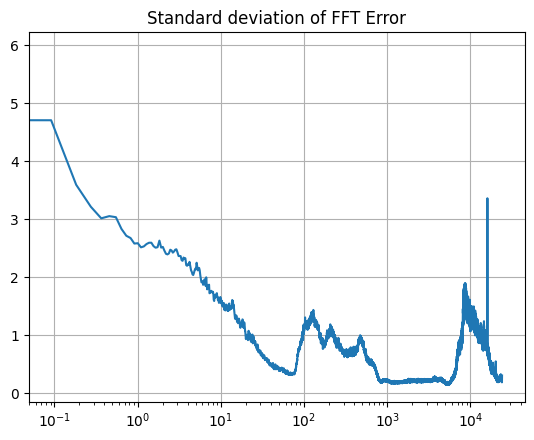

In [33]:
#Averaging FFTs
avg_squared_error = sum_squared_error/num_files
avg_relative_error = sum_relative_error/num_files
avg_original_fft = sum_original_fft/num_files
avg_bwe_fft = sum_bwe_fft/num_files



#Calculate std
fft_errors = np.array(fft_errors)
fft_error_std = np.std(fft_errors, axis=0)


period = 1/fs      
freq = np.fft.rfftfreq(fft_length, period)

def plot_ffts():
        
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    arr = [-10,100]
    
    ax1.plot(freq, np.abs(avg_original_fft-avg_bwe_fft))
    #ax1.plot(freq, avg_bwe_fft)
    ax1.set_title('Average FFT of original ad BWE signal')
    ax1.grid(True)
    ax1.set_xscale('log')
    #ax1.set_ylim(-10,60)
    #ax1.set_xlim(arr)
    
    ax2.plot(freq, avg_squared_error)
    ax2.set_title('Average FFT Error')
    ax2.grid(True)
    ax2.set_xscale('log')
    #ax2.set_ylim(0,2000)
    #ax2.set_xlim(arr)
    
    ax3.plot(freq, 10*np.log(avg_original_fft))
    ax3.plot(freq, 10*np.log(avg_bwe_fft))
    ax3.set_title('Average FFT of original ad BWE signal')
    ax3.grid(True)
    ax3.set_xscale('log')
    #ax3.set_ylim(0,20)
    #ax3.set_xlim(arr)
   
    ax4.plot(freq, 10*np.log(avg_squared_error))
    ax4.set_title('Average FFT Error')
    ax4.grid(True)
    ax4.set_xscale('log')
    #ax4.set_ylim(0,100)
    #ax4.set_xlim(-100, 8000)
    

    #fig.savefig('Results/original_BWE+error.png', dpi=100)

def plot_and_save():
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(freq, avg_original_fft)
    #ax1.set_title("Average FFT of BWE signal")
    
    ax2.plot(freq, avg_original_fft)
    ax2.set_ylim(0,10)
    
    #fig2.suptitle("Average FFT of original signal", fontsize=20)
    fig2.savefig('Results/original_BWE+error.png', dpi=100)


def plot_std():
    plt.plot(freq, fft_error_std)
    plt.title('Standard deviation of FFT Error')
    plt.grid(True)
    plt.xscale('log')
    #plt.ylim(0,2000)
    #plt.xlim(arr)

#plot_and_save()

#plot_ffts()

plot_std()


#plt.plot(freq, fft_error_std)
#plt.title('Standard deviation for the FFT error')
#plt.grid(True)
#plt.ylim(0,80)
#plt.savefig('FFT_error_std.png', dpi=100)


plt.show()

NameError: name 'freq' is not defined

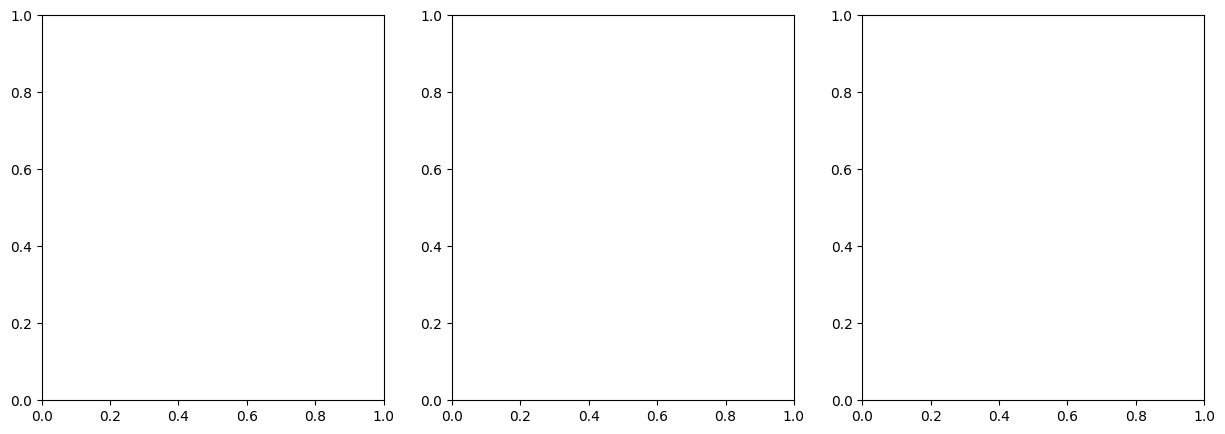

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

#plt.figure(figsize= (10,6)) 
ax1.plot(freq, 10*np.log(avg_original_fft))
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (dB)')
ax1.set_title('Average FFT error')
ax1.grid(True)
#ax1.set_ylim(-0.2,5.2)
#ax1.set_xlim(-100,500)


ax2.plot(freq, 10*np.log(avg_bwe_fft))
ax2.set_xscale('log')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_title('Average FFT of BWE signal')
#ax2.set_yticklabels([])
ax2.grid(True)
#ax2.set_xlim(10,8000)
#ax2.set_ylim(-10,200)

ax3.plot(freq, np.abs(avg_original_fft-avg_bwe_fft))
ax3.set_xscale('log')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_title('Average FFT of BWE signal')
ax3.set_label('Absolute differnece')
ax3.grid(True)
#ax3.set_xlim(10,8000)
#ax3.set_ylim(-10,200)


#fig.tight_layout(pad=1.0)

#plt.savefig('.png', dpi=100)
plt.show()

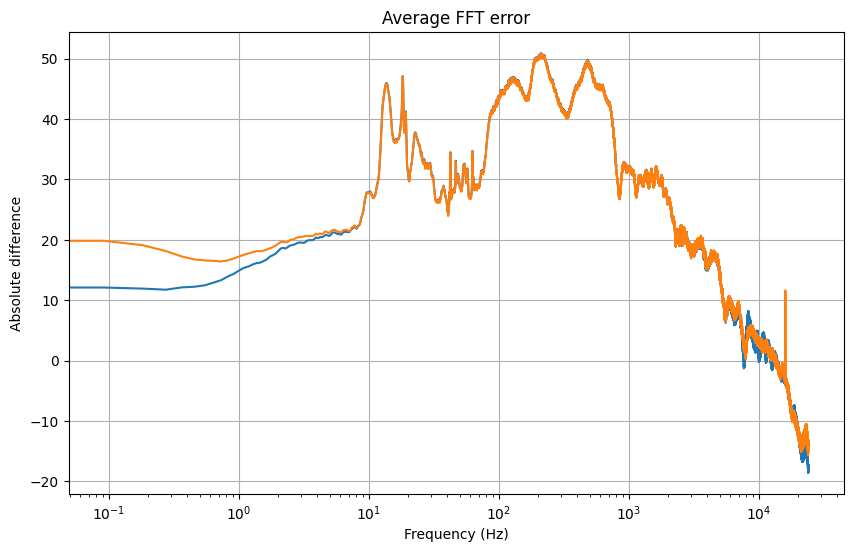

In [25]:
plt.figure(figsize = (10,6)) 
plt.plot(freq, 10*np.log(avg_original_fft))
plt.plot(freq, 10*np.log(avg_bwe_fft))
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Absolute difference')
plt.title('Average FFT error')
plt.grid(True)
#plt.xticks([0,])
#plt.ylim(-0.2,1.5)
#plt.xlim(5000,15000)

plt.savefig('avg_fft_error_6_12k.png', dpi=100)

In [13]:
plt.figure(figsize = (10,6)) 
plt.plot(freq, avg_relative_error)
#plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Absolute difference')
plt.title('Average FFT error')
plt.grid(True)
#plt.xticks([0,])
#plt.ylim(-2,100)
#plt.xlim(5000,15000)

#plt.savefig('avg_fft_error.png', dpi=100)

NameError: name 'freq' is not defined

<Figure size 1000x600 with 0 Axes>

In [30]:
from scipy.signal import firwin, freqz
from scipy.fft import fft, fftfreq

def amp_response_coeff():
    sample_rate = 48000
    cutoff_freq_hz = 8000  # Cutoff frequency in Hz

    # Design an FIR lowpass filter
    numtaps = 64  # Number of taps in the FIR filter
    cutoff_freq = cutoff_freq_hz / (sample_rate / 2)  # Normalize the cutoff frequency
    b = firwin(numtaps, cutoff=cutoff_freq)
    
    # Compute the frequency response of the filter
    w, h = freqz(b, worN=8000)
    w = w * sample_rate / (2 * np.pi)
    
    return w, h
    
    plt.plot(w, 20 * np.log10(abs(h)), label='FIR Filter Amplitude Response')

1.3941769421015255


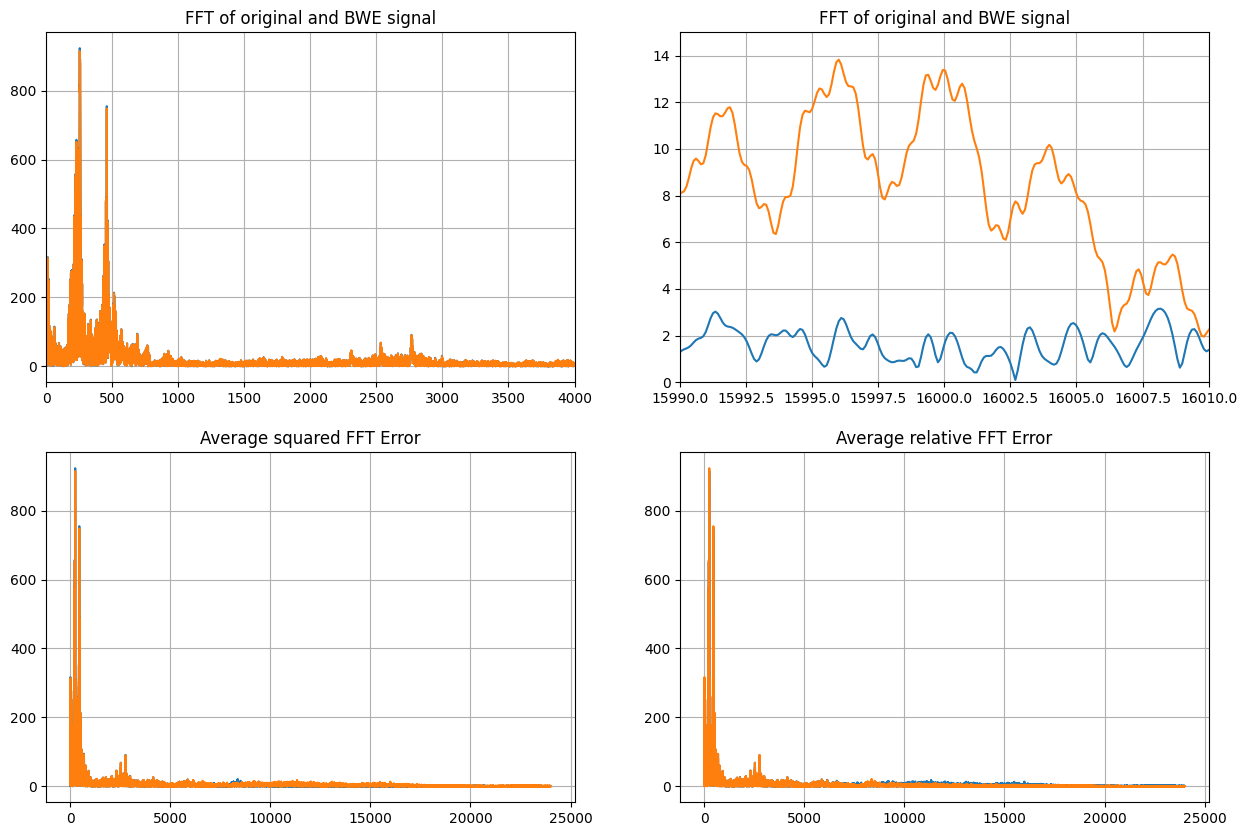

In [83]:
fft_arrays = 'fft_arrayz.npz'

def plot_some_ffts(i):
    with np.load(fft_arrays) as data:
    
        original_fft = data[f'arr1_{i}']
        bwe_fft = data[f'arr2_{i}']
        squared_fft_error = (original_fft - bwe_fft)**2
        relative_fft_error = abs(original_fft - bwe_fft)/original_fft
    
    
    period = 1/fs      
    freq = np.fft.rfftfreq(fft_length, period)
    
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    arr = [8000,25000]
    
    ax1.plot(freq, original_fft)
    ax1.plot(freq, bwe_fft)
    ax1.set_title('FFT of original and BWE signal')
    ax1.grid(True)
    #ax1.set_ylim(0,20)
    ax1.set_xlim(0,4000)
    
    ax2.plot(freq, original_fft)
    ax2.plot(freq, bwe_fft)
    ax2.set_title('Average squared FFT Error')
    ax2.grid(True)
    #ax2.set_ylim(0,20)
    #ax2.set_xlim(arr)
    
    ax3.plot(freq, original_fft)
    ax3.plot(freq, bwe_fft)
    ax3.set_title('FFT of original and BWE signal')
    ax3.grid(True)
    ax3.set_ylim(0,15)
    ax3.set_xlim(15990,16010)
    
    ax4.plot(freq, bwe_fft)
    ax4.plot(freq, original_fft)
    ax4.set_title('Average relative FFT Error')
    ax4.grid(True)
    #ax4.set_ylim(0,2)
    #ax4.set_xlim(7000,24000)
    
    s = int(len(bwe_fft)/24000)
    
    print(np.mean(abs(original_fft-bwe_fft)))

i = 3
plot_some_ffts(i)
plt.show()

In [74]:
folderpath = 'FullBandFiles'
folderlist = os.listdir(folderpath)

for count, filename in enumerate(folderlist):
    filepath = os.path.join(folderpath, filename)
    
    #print(count, filepath)


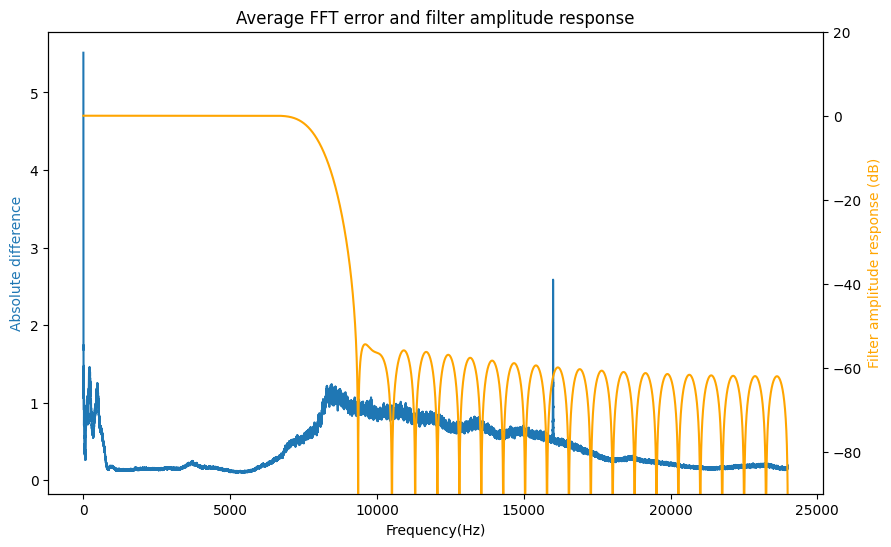

In [48]:
      
w, h = amp_response_coeff()

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot the first set of data
ax1.plot(freq, avg_squared_error, color = 'tab:blue')
ax1.set_xlabel('Frequency(Hz)')
ax1.set_ylabel('Absolute difference', color='tab:blue')
#ax1.set_ylim(-2,62)
#ax1.set_xlim(5000,20000)
#ax1.set_xscale('log')
ax1.set_title('Average FFT error and filter amplitude response')


# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()
ax2.plot(w, 20 * np.log10(abs(h)), color='orange')
ax2.set_ylabel('Filter amplitude response (dB)', color='orange')
ax2.set_ylim(-90, 20)


plt.savefig('FFT_error_and_filter.png', dpi=100)
# Show the plot
plt.show()
